In [1]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
path_train = "../data/train/"

In [3]:
path = "../data/train/"
images_train_path = os.path.join(path,'s2_image')
images_train = sorted(glob.glob(os.path.join(images_train_path, "**/*.tif"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))
mask_train_path = os.path.join(path,'mask')
mask_train = sorted(glob.glob(os.path.join(mask_train_path, "**/*.tif"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_train_path, len(mask_train)))

IMAGES ../data/train/s2_image ### Total:  2066
MASK ../data/train/mask ### Total:  2066


In [4]:
images_train

['../data/train/s2_image/train_s2_image_0.tif',
 '../data/train/s2_image/train_s2_image_1.tif',
 '../data/train/s2_image/train_s2_image_10.tif',
 '../data/train/s2_image/train_s2_image_100.tif',
 '../data/train/s2_image/train_s2_image_1000.tif',
 '../data/train/s2_image/train_s2_image_1001.tif',
 '../data/train/s2_image/train_s2_image_1002.tif',
 '../data/train/s2_image/train_s2_image_1003.tif',
 '../data/train/s2_image/train_s2_image_1004.tif',
 '../data/train/s2_image/train_s2_image_1005.tif',
 '../data/train/s2_image/train_s2_image_1006.tif',
 '../data/train/s2_image/train_s2_image_1007.tif',
 '../data/train/s2_image/train_s2_image_1008.tif',
 '../data/train/s2_image/train_s2_image_1009.tif',
 '../data/train/s2_image/train_s2_image_101.tif',
 '../data/train/s2_image/train_s2_image_1010.tif',
 '../data/train/s2_image/train_s2_image_1011.tif',
 '../data/train/s2_image/train_s2_image_1012.tif',
 '../data/train/s2_image/train_s2_image_1013.tif',
 '../data/train/s2_image/train_s2_image_1

In [5]:
import rioxarray as rxr
import matplotlib

In [9]:
data = rxr.open_rasterio(mask_train[0], masked=False)
data.shape

/home/sebastien/miniconda3/envs/solafune/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


(1, 24, 23)

In [69]:
import matplotlib.pyplot as plt 
data = rxr.open_rasterio(images_train[1300], masked=False)
data = data.values

/home/sebastien/miniconda3/envs/solafune/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


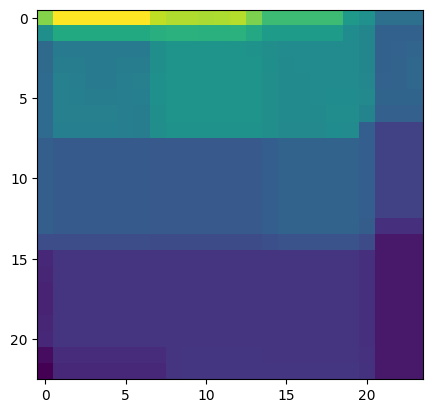

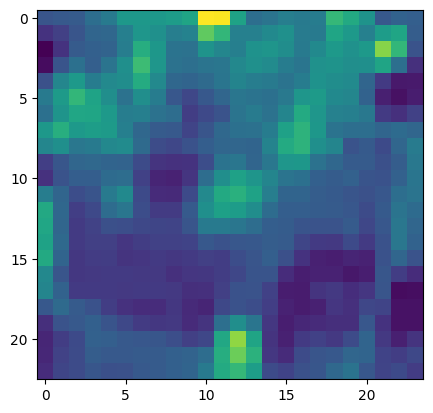

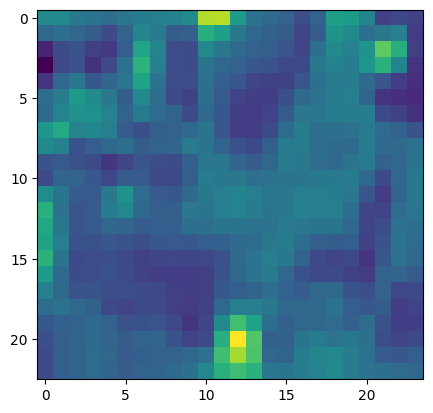

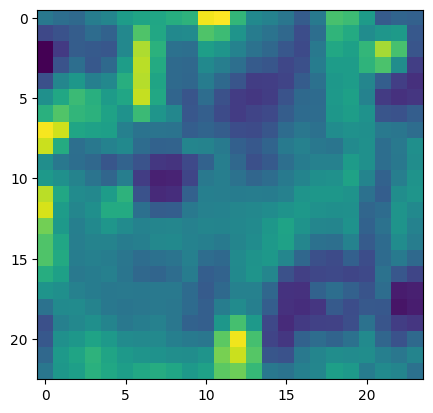

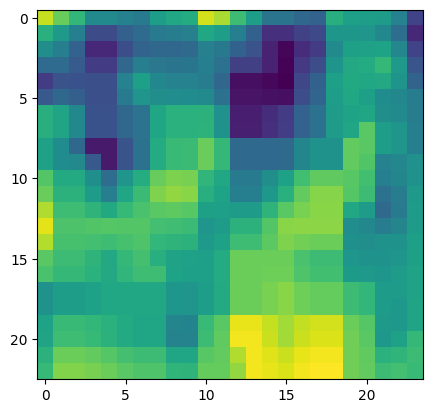

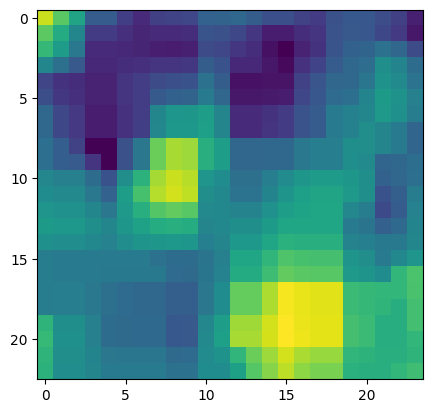

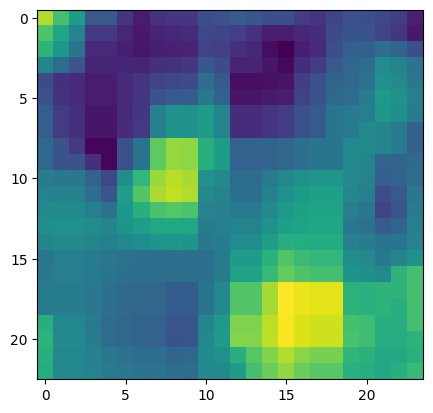

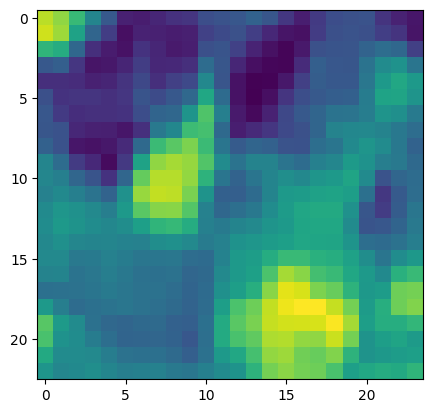

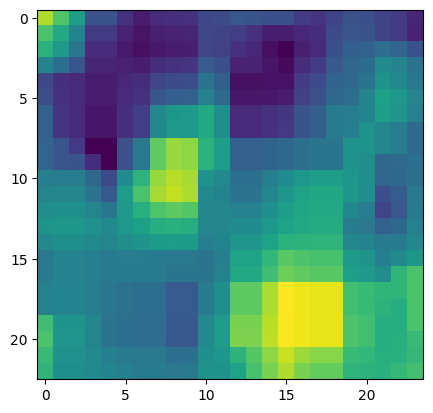

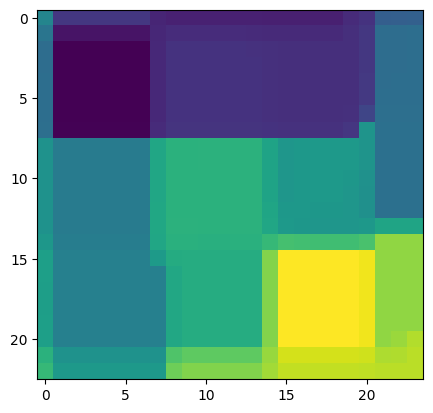

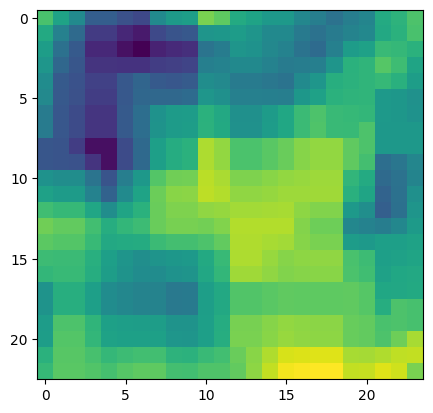

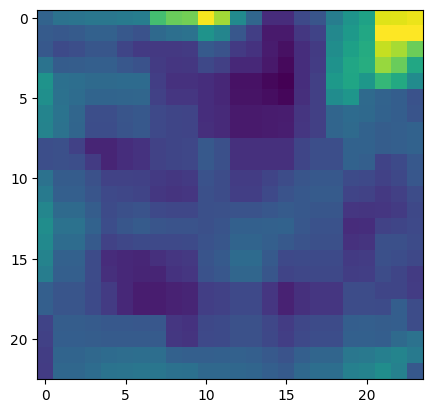

In [70]:
for i in range(data.shape[0]):

    plt.imshow(data[i,:,:])
    plt.show()

/home/sebastien/miniconda3/envs/solafune/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


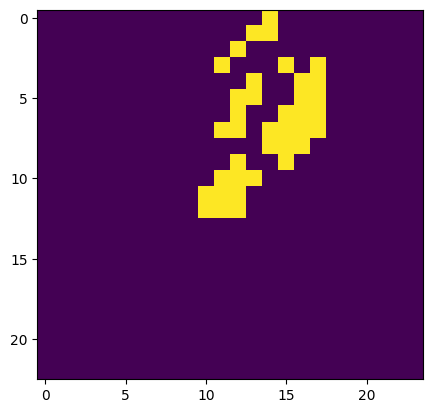

In [71]:
mask = rxr.open_rasterio(mask_train[1300], masked=False)
plt.imshow(mask.values[0,:,:])

In [72]:
# TODO
# Generate Dataframe train/test
# Generate Dataframe valid
# Save as CSV
# Dataloader modification
# Metrics modification
# Loss modification BCE